#IMPORTING DATA FROM AMAZON S3 AND REQUIRED PACKAGES

In [ ]:
%%bash

pip install pyspark 
wget https://bdadata.s3.amazonaws.com/Uber.csv
wget https://bdadata.s3.amazonaws.com/Lyft-3.csv

  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b7ba5cc9922804163a79af138a81f919f7e83230b3e3d9578d1632dca31732e0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


--2022-05-05 23:30:11--  https://bdadata.s3.amazonaws.com/Uber.csv
Resolving bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)... 54.231.136.185
Connecting to bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)|54.231.136.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93005622 (89M) [text/csv]
Saving to: ‘Uber.csv’

     0K .......... .......... .......... .......... ..........  0%  793K 1m54s
    50K .......... .......... .......... .......... ..........  0%  800K 1m54s
   100K .......... .......... .......... .......... ..........  0%  804K 1m53s
   150K .......... .......... .......... .......... ..........  0% 67.8M 85s
   200K .......... .......... .......... .......... ..........  0%  817K 90s
   250K .......... .......... .......... .......... ..........  0% 59.3M 76s
   300K .......... .......... .......... .......... ..........  0% 66.4M 65s
   350K .......... .......... .......... .......... ..........  0% 83.4M 57s
   400K .......... ........

In [ ]:
#import the required libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import FloatType
from shapely.geometry import Point,Polygon
import descartes
from pyspark.ml import Pipeline
from pyspark.ml import feature, regression
import plotly.express as px
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as fn, Row
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

#create and initialize spark session and context
spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction","0.8")\
  .config("spark.executor.memory","12g")\
  .config("spark.driver.memory","12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .config("spark.driver.maxResultSize","0")\
  .getOrCreate()

sc=spark.sparkContext


#CORRELATION FOR UBER

In [ ]:
uber_df = spark.read.option("inferSchema","true").option("header","true").csv("/content/Uber.csv")
uber_df_1 = uber_df.drop("_c0","long_summary","apparentTemperatureHighTime","apparentTemperatureLowTime","cab_type")

In [ ]:
source_df = uber_df_1.select("source","destination","name")

In [ ]:
source_indexer = feature.StringIndexerModel.from_labels(['Haymarket Square','Back Bay','North End','North Station',\
       'Beacon Hill','Boston University','Fenway','South Station',\
       'Theatre District','West End','Financial District',\
       'Northeastern University'], inputCol="source", outputCol='source_categorical')

destination_indexer = feature.StringIndexerModel.from_labels(['Haymarket Square', 'Back Bay', 'North End', 'North Station',
       'Beacon Hill', 'Boston University', 'Fenway', 'South Station',
       'Theatre District', 'West End', 'Financial District',
       'Northeastern University'], inputCol ="destination", outputCol='destination_categorical')

name_indexer = feature.StringIndexerModel.from_labels(["UberX","UberPool","WAV","UberXL","Black","Black SUV"], 
                                                          inputCol="name", outputCol='name_categorical')

summary_indexer = feature.StringIndexerModel.from_labels([' Mostly Cloudy ', ' Rain ', ' Clear ', ' Partly Cloudy ',' Overcast ', ' Light Rain ',\
                                                          ' Foggy ', ' Possible Drizzle ',' Drizzle '], 
                                                         inputCol="short_summary", outputCol='summary_categorical')

indexer_pipeline = Pipeline(stages = [source_indexer,destination_indexer,name_indexer,summary_indexer])
indexed_df = indexer_pipeline.fit(uber_df).transform(uber_df).drop("_c0","source","destination","cab_type","name","short_summary","long_summary","apparentTemperatureHighTime","apparentTemperatureLowTime")


In [ ]:
indexed_df.show()

+----+---+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+----------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+------------------+-----------------------+----------------+-------------------+
|hour|day|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureLow|dewPoint|pressure|windBearing|cloudCover|uvIndex|ozone|moonPhase|precipIntensityMax|temperatureMin|temperatureMax|apparentTemperatureMin|apparentTemperatureMax|source_categorical|destination_categorical|name_categorical|summary_categorical|
+----+---+-----+--------+-----

In [ ]:
indexed_df.columns

['hour',
 'day',
 'price',
 'distance',
 'surge_multiplier',
 'latitude',
 'longitude',
 'temperature',
 'apparentTemperature',
 'precipIntensity',
 'precipProbability',
 'humidity',
 'windSpeed',
 'windGust',
 'visibility',
 'temperatureHigh',
 'temperatureLow',
 'apparentTemperatureHigh',
 'apparentTemperatureLow',
 'dewPoint',
 'pressure',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'ozone',
 'moonPhase',
 'precipIntensityMax',
 'temperatureMin',
 'temperatureMax',
 'apparentTemperatureMin',
 'apparentTemperatureMax',
 'source_categorical',
 'destination_categorical',
 'name_categorical',
 'summary_categorical']

In [ ]:
temperature_cols = ["Price"]
for i in indexed_df.columns:
  if "temperature" in i.lower():
    temperature_cols.append(i)
temperature_cols

['Price',
 'temperature',
 'apparentTemperature',
 'temperatureHigh',
 'temperatureLow',
 'apparentTemperatureHigh',
 'apparentTemperatureLow',
 'temperatureMin',
 'temperatureMax',
 'apparentTemperatureMin',
 'apparentTemperatureMax']

In [ ]:
temperature_df = indexed_df.select(temperature_cols)

In [ ]:
#applying VectorAssembler on the temp column and transforming the DF
corr_assembler_temp = feature.VectorAssembler(inputCols = temperature_cols,outputCol = "features").transform(temperature_df)
corr_assembler_temp.show()

+-----+-----------+-------------------+---------------+--------------+-----------------------+----------------------+--------------+--------------+----------------------+----------------------+--------------------+
|Price|temperature|apparentTemperature|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureLow|temperatureMin|temperatureMax|apparentTemperatureMin|apparentTemperatureMax|            features|
+-----+-----------+-------------------+---------------+--------------+-----------------------+----------------------+--------------+--------------+----------------------+----------------------+--------------------+
| 12.0|      40.13|              38.08|          42.52|         31.71|                  40.53|                 28.06|         28.79|         42.52|                 26.41|                 40.53|[12.0,40.13,38.08...|
| 16.0|      20.38|              20.38|          33.83|         27.27|                  32.85|                 24.61|         18.29|        

In [ ]:
#computes the correlation based on the features column and returns the first row, first column value
corr_temp = Correlation.corr(corr_assembler_temp,"features").collect()[0][0]
corr_temp

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


DenseMatrix(11, 11, [1.0, 0.0017, 0.0006, -0.0005, -0.0011, -0.001, -0.0007, 0.0012, ..., 0.9508, 0.5816, 0.9741, 0.5603, 0.6483, 0.9561, 0.7419, 1.0], False)

In [ ]:
#convert the above result into a list to display the values
tempCorr_array = corr_temp.toArray().tolist() 
print(tempCorr_array)

[[1.0, 0.0016974702103517872, 0.0006422297538421133, -0.0005158293216116987, -0.0010919349985266127, -0.000989350822568834, -0.0006821237934464973, 0.0012374669177824043, -0.00011669211263985094, -6.621987485578146e-05, -0.0004822354612866557], [0.0016974702103517872, 1.0, 0.9461769717077658, 0.7898052644305004, 0.5036341341575641, 0.7112762527625358, 0.38427981513754517, 0.7899880881937142, 0.7817051696570549, 0.8181396169761024, 0.7040299332102936], [0.0006422297538421133, 0.9461769717077658, 1.0, 0.8224266654554799, 0.57538157797999, 0.8124594666507543, 0.49735112657637787, 0.6979846427358527, 0.7933488635416422, 0.7870993169741068, 0.7830915486815483], [-0.0005158293216116987, 0.7898052644305004, 0.8224266654554799, 1.0, 0.6134981936098653, 0.9585616901790209, 0.5367102696019447, 0.7949309628698187, 0.9858716462795437, 0.877814948502209, 0.9507644374077094], [-0.0010919349985266127, 0.5036341341575641, 0.57538157797999, 0.6134981936098653, 1.0, 0.6314126725257921, 0.933889343949245

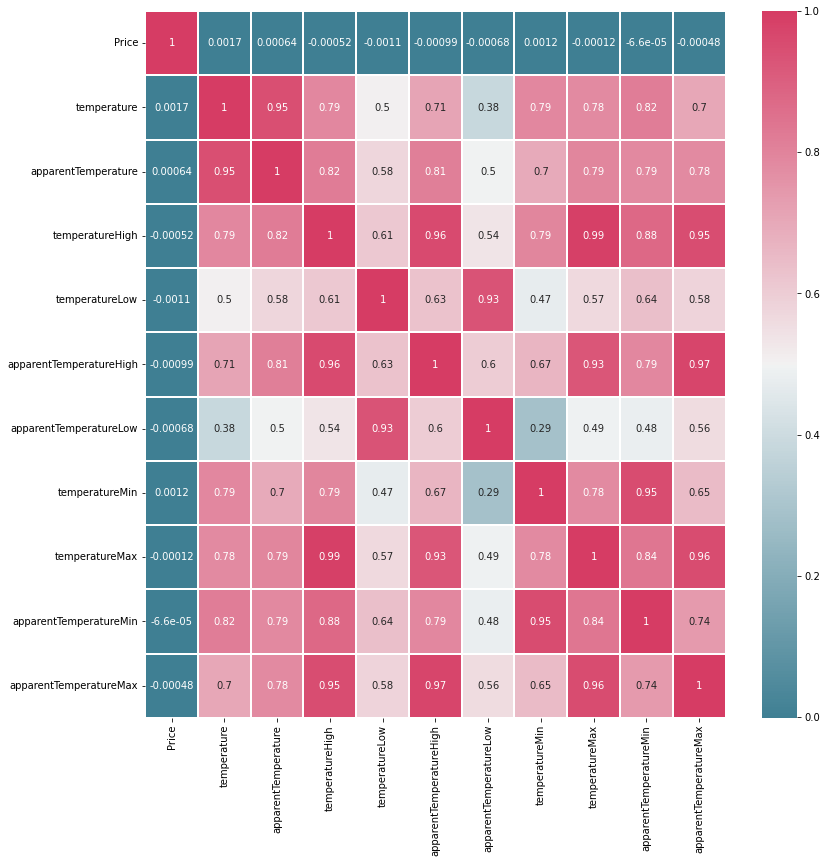

In [ ]:
#plots a heatmap which shows the correlation of each column with respect to others
cmap = sns.diverging_palette(220,2,as_cmap = True)
plt.figure(figsize=(13,13))
sns.heatmap(tempCorr_array,linewidth=1.0,cmap=cmap,annot = True,yticklabels=temperature_cols,xticklabels=temperature_cols)

In [ ]:
climate_cols = ["precipIntensity","precipProbability","humidity","windSpeed","windGust","visibility","dewPoint","pressure","windBearing","cloudCover","uvIndex","ozone","moonPhase","precipIntensityMax","Price"]

In [ ]:
climate_df = indexed_df.select(climate_cols)

In [ ]:
#applying VectorAssembler on the temp column and transforming the DF
corr_assembler_climate = feature.VectorAssembler(inputCols = climate_cols,outputCol = "features").transform(climate_df)
corr_assembler_climate.show()

+---------------+-----------------+--------+---------+--------+----------+--------+--------+-----------+----------+-------+-----+---------+------------------+-----+--------------------+
|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|dewPoint|pressure|windBearing|cloudCover|uvIndex|ozone|moonPhase|precipIntensityMax|Price|            features|
+---------------+-----------------+--------+---------+--------+----------+--------+--------+-----------+----------+-------+-----+---------+------------------+-----+--------------------+
|            0.0|              0.0|     0.6|     3.38|    3.99|     9.833|   27.31| 1017.16|        281|       1.0|      0|281.8|     0.79|            3.0E-4| 12.0|[0.0,0.0,0.6,3.38...|
|            0.0|              0.0|    0.66|     2.94|    3.22|     9.831|   10.87| 1031.51|          2|      0.03|      0|327.3|     0.21|            1.0E-4| 16.0|[0.0,0.0,0.66,2.9...|
|            0.0|              0.0|    0.56|     2.65|    3.83|     9.

In [ ]:
#computes the correlation based on the features column and returns the first row, first column value
corr_climate = Correlation.corr(corr_assembler_climate,"features").collect()[0][0]
corr_climate

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


DenseMatrix(15, 15, [1.0, 0.8379, 0.4177, 0.309, 0.1983, -0.5994, 0.3394, -0.1457, ..., -0.0021, -0.0023, 0.0022, -0.0005, 0.002, -0.0008, 0.0037, 1.0], False)

In [ ]:
#convert the above result into a list to display the values
climateCorr_array = corr_climate.toArray().tolist() 
print(climateCorr_array)

[[1.0, 0.8379330922516877, 0.41773943216714093, 0.30896177078330594, 0.19829616579318246, -0.5994250261590094, 0.3394204326719139, -0.14566977817035878, -0.4337513843226781, 0.2894634389647784, -0.10134171873990906, -0.2241282393697694, 0.07972038895482352, 0.5008229243282126, 0.0016471023742402875], [0.8379330922516877, 1.0, 0.5496864889328985, 0.25482715268631695, 0.12932189510207542, -0.7619575918457616, 0.44536734666413574, -0.18098038585978854, -0.4719068049688273, 0.3883833775665728, -0.0741055559273901, -0.235302779232557, 0.0836084192168388, 0.5846037355309258, 0.0015346324201277065], [0.41773943216714093, 0.5496864889328985, 1.0, -0.20459211556430643, -0.3049899239157265, -0.6973061192541966, 0.7488304082608761, -0.13488095403949588, -0.35745066397978537, 0.48323504350309987, -0.21026793204664343, -0.42613531108770203, 0.1459751045570527, 0.5202722105977455, -0.0008601609189212053], [0.30896177078330594, 0.25482715268631695, -0.20459211556430643, 1.0, 0.9372499408899928, -0.03

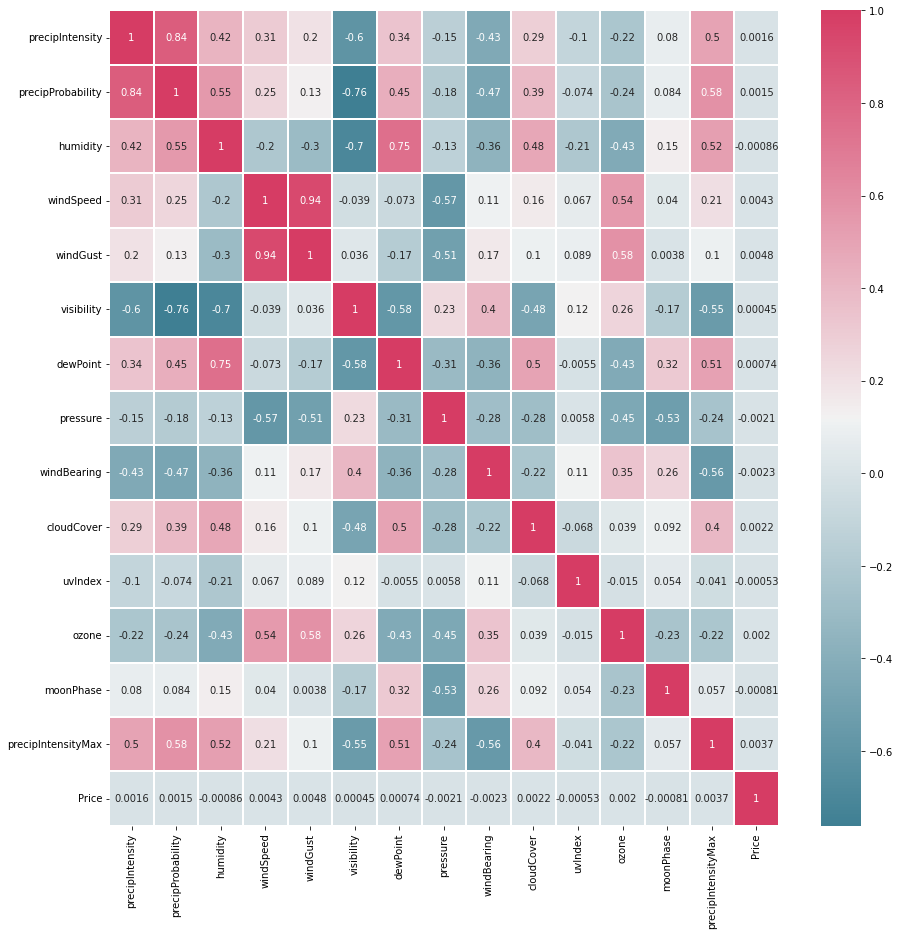

In [ ]:
#plots a heatmap which shows the correlation of each column with respect to others
cmap = sns.diverging_palette(220,2,as_cmap = True)
plt.figure(figsize=(15,15))
sns.heatmap(climateCorr_array,linewidth=1.0,cmap=cmap,annot = True,yticklabels=climate_cols,xticklabels=climate_cols)

In [ ]:
other_cols = ["hour","day","distance","source_categorical","destination_categorical","name_categorical","summary_categorical","price"]

In [ ]:
other_df = indexed_df.select(other_cols)

In [ ]:
#applying VectorAssembler on the temp column and transforming the DF
corr_assembler_other = feature.VectorAssembler(inputCols = other_cols,outputCol = "features").transform(other_df)
corr_assembler_other.show()

+----+---+--------+------------------+-----------------------+----------------+-------------------+-----+--------------------+
|hour|day|distance|source_categorical|destination_categorical|name_categorical|summary_categorical|price|            features|
+----+---+--------+------------------+-----------------------+----------------+-------------------+-----+--------------------+
|  22| 30|    1.11|               2.0|                    9.0|             3.0|                4.0| 12.0|[22.0,30.0,1.11,2...|
|  10| 13|    1.11|               2.0|                    9.0|             4.0|                2.0| 16.0|[10.0,13.0,1.11,2...|
|  19| 13|    1.11|               2.0|                    9.0|             0.0|                0.0|  7.5|[19.0,13.0,1.11,2...|
|  23| 16|    1.11|               2.0|                    9.0|             2.0|                5.0|  7.5|[23.0,16.0,1.11,2...|
|   0| 14|    1.11|               2.0|                    9.0|             5.0|                4.0| 26.0|[0.0,1

In [ ]:
#computes the correlation based on the features column and returns the first row, first column value
corr_other = Correlation.corr(corr_assembler_other,"features").collect()[0][0]
corr_other

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


DenseMatrix(8, 8, [1.0, 0.0643, 0.0032, 0.004, -0.0031, 0.0002, 0.0993, 0.0009, ..., 0.0009, 0.0013, 0.3362, 0.0819, 0.0676, 0.8199, -0.0012, 1.0], False)

In [ ]:
#convert the above result into a list to display the values
otherCorr_array = corr_other.toArray().tolist() 
print(otherCorr_array)

[[1.0, 0.06425091327364295, 0.003180107669530833, 0.003982329403145085, -0.003126890320961572, 0.00016120206769475604, 0.09933389364004555, 0.0008674634622081651], [0.06425091327364295, 1.0, 0.002759787582596244, -0.0004704055668510133, -0.0029758831766681718, 0.0007732908740605025, -0.08685714696117226, 0.0013419241698695572], [0.003180107669530833, 0.002759787582596244, 1.0, 0.2664183971728313, 0.20432971747365927, -2.2990898812100533e-06, -0.00020928293637851903, 0.33620376616597236], [0.003982329403145085, -0.0004704055668510133, 0.2664183971728313, 1.0, -0.004460736694286383, 5.331840630245471e-06, -6.267150141133016e-05, 0.08188157459317341], [-0.003126890320961572, -0.0029758831766681718, 0.20432971747365927, -0.004460736694286383, 1.0, -5.688677508526394e-06, -7.748085189609114e-05, 0.0676014728791426], [0.00016120206769475604, 0.0007732908740605025, -2.2990898812100533e-06, 5.331840630245471e-06, -5.688677508526394e-06, 1.0, -0.002425584734579003, 0.8198872462204199], [0.09933

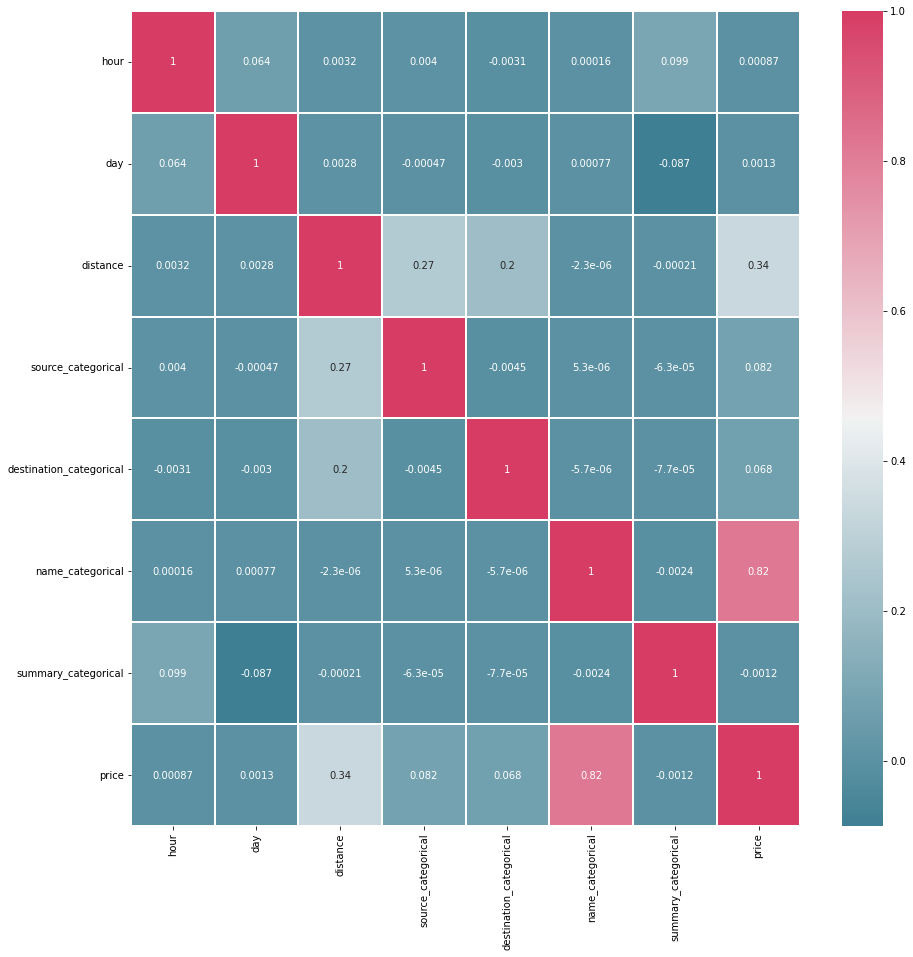

In [ ]:
#plots a heatmap which shows the correlation of each column with respect to others
cmap = sns.diverging_palette(220,2,as_cmap = True)
plt.figure(figsize=(15,15))
sns.heatmap(otherCorr_array,linewidth=1.0,cmap=cmap,annot = True,yticklabels=other_cols,xticklabels=other_cols)

In [ ]:
train_df,test_df,validate_df = indexed_df.randomSplit([0.6,0.2,0.2])
def col_sel(cols):
  best_cols = ["price"]
  models_consider = []
  r2_vals = []
  r2_final = 0
  for i in cols:
    if i not in best_cols:
      best_cols.append(i)
      print(i)
      va_cols = best_cols[1:]
      va = feature.VectorAssembler(inputCols=va_cols,outputCol="features")
      lr = regression.LinearRegression(featuresCol = "features",labelCol = "price")
      forward_pipe = Pipeline(stages = [va,lr])
      print("Executing ", best_cols)
      model_df = train_df.select(best_cols)
      pipe_fit = forward_pipe.fit(model_df)
      transformed_df = pipe_fit.transform(model_df)
      lr_model = pipe_fit.stages[-1]
      r2_score = lr_model.summary.r2
      print(r2_score)
      #r2_vals.append(r2_score)
      if r2_score != 1:
        r2_vals.append(r2_score)
        if r2_score > r2_final:
          r2_final = r2_final+r2_score
          models_consider.append(i)
          print(r2_vals)
          print("Model Consider: ",models_consider)
          print("################################")

  return models_consider

In [ ]:
col_sel(indexed_df.columns)

hour
Executing  ['price', 'hour']
3.022935801344495e-06
[3.022935801344495e-06]
Model Consider:  ['hour']
################################
day
Executing  ['price', 'hour', 'day']
5.698220765237849e-06
[3.022935801344495e-06, 5.698220765237849e-06]
Model Consider:  ['hour', 'day']
################################
distance
Executing  ['price', 'hour', 'day', 'distance']
0.11231622230665828
[3.022935801344495e-06, 5.698220765237849e-06, 0.11231622230665828]
Model Consider:  ['hour', 'day', 'distance']
################################
surge_multiplier
Executing  ['price', 'hour', 'day', 'distance', 'surge_multiplier']
0.11231622230665217
latitude
Executing  ['price', 'hour', 'day', 'distance', 'surge_multiplier', 'latitude']
0.11232156119836922
longitude
Executing  ['price', 'hour', 'day', 'distance', 'surge_multiplier', 'latitude', 'longitude']
0.11232463954332661
temperature
Executing  ['price', 'hour', 'day', 'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature']
0.1123

['hour', 'day', 'distance', 'temperature', 'name_categorical']

#LINEAR REGRESSION MODEL ANALYSIS FOR UBER - PRICE PREDICTION

In [ ]:
#PCA Model

In [ ]:
va = VectorAssembler(inputCols=['hour','day','distance','surge_multiplier','latitude','longitude','temperature','apparentTemperature',
 'precipIntensity','precipProbability','humidity','windSpeed','windGust','visibility','temperatureHigh','temperatureLow',
 'apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex','ozone',
 'moonPhase','precipIntensityMax','temperatureMin','temperatureMax','apparentTemperatureMin','apparentTemperatureMax','source_categorical',
 'destination_categorical','name_categorical','summary_categorical'], outputCol="temp_feature")
pca_data = feature.PCA(k=10,inputCol='temp_feature',outputCol='pca_val')
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="pca_val", outputCol="scaled")
lr = regression.LinearRegression(featuresCol = "scaled",labelCol = "price")

In [ ]:
train_df,test_df,validate_df = indexed_df.randomSplit([0.6,0.2,0.2])
Pipleline_scaled = Pipeline(stages=[va,pca_data,sScaler,lr])
scaled_pipe = Pipleline_scaled.fit(train_df)

In [ ]:
scaled_pipe.transform(test_df).toPandas().head()
mse = fn.mean((fn.col('price') - fn.col('prediction'))**2).alias('mse') # Calculating the mean squared error
scaled_pipe.transform(test_df).select(mse).show() # Displaying the mse

+-----------------+
|              mse|
+-----------------+
|73.10750504424311|
+-----------------+



In [ ]:
scaled_pipe.transform(validate_df).select(mse).show() # Displaying the mse

+-----------------+
|              mse|
+-----------------+
|73.66948290466965|
+-----------------+



In [ ]:
lr_model = scaled_pipe.stages[-1]
lr_model.summary.r2

3.429091363871262e-05

Linear Regression Model with Name and distance

In [ ]:
input_cols = ["name_categorical","distance"]
train_df,test_df,validate_df = indexed_df.randomSplit([0.6,0.2,0.2])
va = feature.VectorAssembler(inputCols = input_cols,outputCol = "features")
lr = regression.LinearRegression(featuresCol = "features",labelCol = "price")

In [ ]:
lr_pipe = Pipeline(stages = [va,lr]).fit(train_df)

In [ ]:
prediction_df_lr = lr_pipe.transform(test_df).toPandas()
mse = fn.mean((fn.col('price') - fn.col('prediction'))**2).alias('mse') # Calculating the mean squared error
lr_pipe.transform(test_df).select(mse).show() # Displaying the mse

+------------------+
|               mse|
+------------------+
|15.743692934247035|
+------------------+



In [ ]:
prediction_df_lr

,hour,day,price,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,precipIntensity,...,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,source_categorical,destination_categorical,name_categorical,summary_categorical,features,prediction
0,0,1,5.5,0.39,1.0,42.3503,-71.081,38.72,36.65,0.0,...,28.64,42.32,29.29,40.48,10.0,7.0,1.0,4.0,"[1.0, 0.39]",5.232187
1,0,1,5.5,0.56,1.0,42.3503,-71.081,38.72,36.65,0.0,...,28.64,42.32,29.29,40.48,3.0,0.0,1.0,4.0,"[1.0, 0.56]",5.647067
2,0,1,6.0,0.39,1.0,42.3503,-71.081,38.72,36.65,0.0,...,28.64,42.32,29.29,40.48,10.0,7.0,0.0,4.0,"[0.0, 0.39]",1.122798
3,0,1,6.0,0.56,1.0,42.3503,-71.081,38.72,36.65,0.0,...,28.64,42.32,29.29,40.48,3.0,0.0,0.0,4.0,"[0.0, 0.56]",1.537678
4,0,1,6.5,0.99,1.0,42.3503,-71.081,38.72,36.65,0.0,...,28.64,42.32,29.29,40.48,0.0,10.0,1.0,4.0,"[1.0, 0.99]",6.696468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66384,23,30,29.5,2.27,1.0,42.2148,-71.033,38.62,35.98,0.0,...,28.90,42.13,26.20,40.95,4.0,5.0,5.0,4.0,"[5.0, 2.27]",26.257824
66385,23,30,29.5,2.45,1.0,42.2148,-71.033,38.62,35.98,0.0,...,28.90,42.13,26.20,40.95,5.0,8.0,5.0,4.0,"[5.0, 2.45]",26.697108
66386,23,30,30.5,2.66,1.0,42.2148,-71.033,38.62,35.98,0.0,...,28.90,42.13,26.20,40.95,6.0,8.0,5.0,4.0,"[5.0, 2.66]",27.209607
66387,23,30,33.0,3.07,1.0,42.2148,-71.033,38.62,35.98,0.0,...,28.90,42.13,26.20,40.95,6.0,3.0,5.0,4.0,"[5.0, 3.07]",28.210199


In [ ]:
prediction_df_lr[["price","prediction","name_categorical"]]

,price,prediction,name_categorical
0,5.5,5.232187,1.0
1,5.5,5.647067,1.0
2,6.0,1.122798,0.0
3,6.0,1.537678,0.0
4,6.5,6.696468,1.0
...,...,...,...
66384,29.5,26.257824,5.0
66385,29.5,26.697108,5.0
66386,30.5,27.209607,5.0
66387,33.0,28.210199,5.0


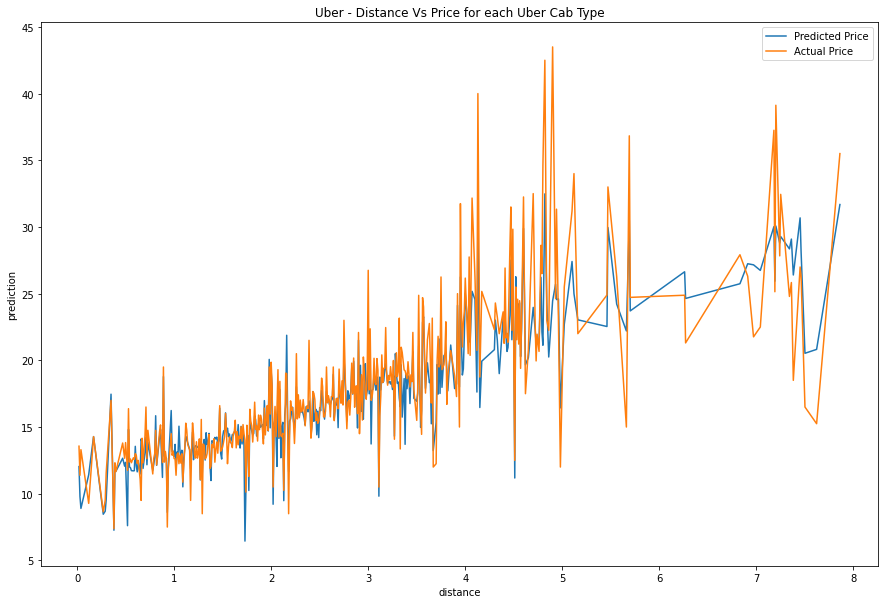

In [ ]:
#2.
plt.figure(figsize=(15, 10))
sns.lineplot(data=prediction_df_lr, x="distance", y="prediction",ci=None).set_title("Uber - Distance Vs Price for each Uber Cab Type");
sns.lineplot(data=prediction_df_lr, x="distance", y="price",ci=None).set_title("Uber - Distance Vs Price for each Uber Cab Type");
plt.legend(labels=["Predicted Price","Actual Price"])


In [ ]:
lr_pipe.transform(validate_df).select(mse).show() # Displaying the mse

+------------------+
|               mse|
+------------------+
|15.518344584868768|
+------------------+



In [ ]:
lr_model = lr_pipe.stages[-1]
lr_model.coefficients

DenseVector([4.1094, 2.4405])

In [ ]:
lr_model.intercept

0.17101516393111862

In [ ]:
coeff_tuple = list(zip(input_cols,list(lr_model.coefficients)))
coeff_df = pd.DataFrame(coeff_tuple).rename(columns = {0:"Features",1:"Coefficients"})
coeff_df

,Features,Coefficients
0,name_categorical,4.109389
1,distance,2.440469


In [ ]:
lr_pipe.transform(validate_df).select(mse).show() # Displaying the mse

+------------------+
|               mse|
+------------------+
|15.518344584868768|
+------------------+



In [ ]:
lr_model.summary.r2

0.7844980446795286

In [ ]:
enable_grid = False
if enable_grid == False:
    all_models = []
    grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0., 0.05, 0.10,0.20,0.30,0.40,0.50]).\
    addGrid(lr.elasticNetParam,[0.0,0.2,0.4,0.6,0.8,0.85,0.90]).\
    build()
    grid
    lr_pipe_1 = Pipeline(stages=[va,lr])
    for j in range(len(grid)):
        model = lr_pipe_1.fit(train_df,grid[j])
        all_models.append(model)
    pass

In [ ]:
accuracies = [m.\
transform(validate_df).\
select(fn.avg(fn.expr('float(prediction)')).alias('accuracy')).\
first().\
accuracy for m in all_models]
accuracies
best_model_idx = np.argmax(accuracies)
print(grid[best_model_idx])

{Param(parent='LinearRegression_7b7ef66b0ee8', name='regParam', doc='regularization parameter (>= 0).'): 0.5, Param(parent='LinearRegression_7b7ef66b0ee8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.9}


In [ ]:
lr_new = regression.LinearRegression(featuresCol = "features",labelCol = "price",regParam=0.0,elasticNetParam=0.0)

In [ ]:
lr_pipe_new = Pipeline(stages = [va,lr_new]).fit(train_df)

In [ ]:
lr_pipe_new.transform(test_df).select(mse).show()

+------------------+
|               mse|
+------------------+
|15.743692934247035|
+------------------+



In [ ]:
lr_model_new = lr_pipe_new.stages[-1]
lr_model_new.summary.r2

0.7844980446795286

#RANDOM FOREST REGRESSION FOR UBER - PRICE PREDICTION

In [ ]:
indexed_df_rf = indexed_df.withColumn("label",indexed_df.price)
indexed_df_rf = indexed_df_rf.drop("price")
indexed_df_rf.show()

+----+---+--------+----------------+--------+---------+-----------+-------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+----------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+------------------+-----------------------+----------------+-------------------+-----+
|hour|day|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureLow|dewPoint|pressure|windBearing|cloudCover|uvIndex|ozone|moonPhase|precipIntensityMax|temperatureMin|temperatureMax|apparentTemperatureMin|apparentTemperatureMax|source_categorical|destination_categorical|name_categorical|summary_categorical|label|
+----+---+--------+-----------

In [ ]:
train_df,test_df,validate_df = indexed_df_rf.randomSplit([0.6,0.2,0.2])

In [ ]:
rf = regression.RandomForestRegressor(labelCol="label",featuresCol="features")

In [ ]:
rf_pipe = Pipeline(stages = [va,rf]).fit(train_df)

In [ ]:
predictions = rf_pipe.transform(test_df)

In [ ]:
predictions.head()

Row(hour=0, day=1, distance=0.49, surge_multiplier=1.0, latitude=42.3503, longitude=-71.081, temperature=38.72, apparentTemperature=36.65, precipIntensity=0.0, precipProbability=0.0, humidity=0.64, windSpeed=3.23, windGust=3.53, visibility=9.725, temperatureHigh=42.32, temperatureLow=31.57, apparentTemperatureHigh=40.48, apparentTemperatureLow=28.1, dewPoint=27.43, pressure=1017.51, windBearing=292, cloudCover=1.0, uvIndex=0, ozone=288.7, moonPhase=0.79, precipIntensityMax=0.0004, temperatureMin=28.64, temperatureMax=42.32, apparentTemperatureMin=29.29, apparentTemperatureMax=40.48, source_categorical=0.0, destination_categorical=3.0, name_categorical=3.0, summary_categorical=4.0, label=10.5, features=DenseVector([3.0, 0.49]), prediction=12.42223142929862)

In [ ]:
evaluator =   RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
accuracy = evaluator.evaluate(predictions)

In [ ]:
accuracy

0.9284698891428034

In [ ]:
pred_pd = predictions.toPandas()

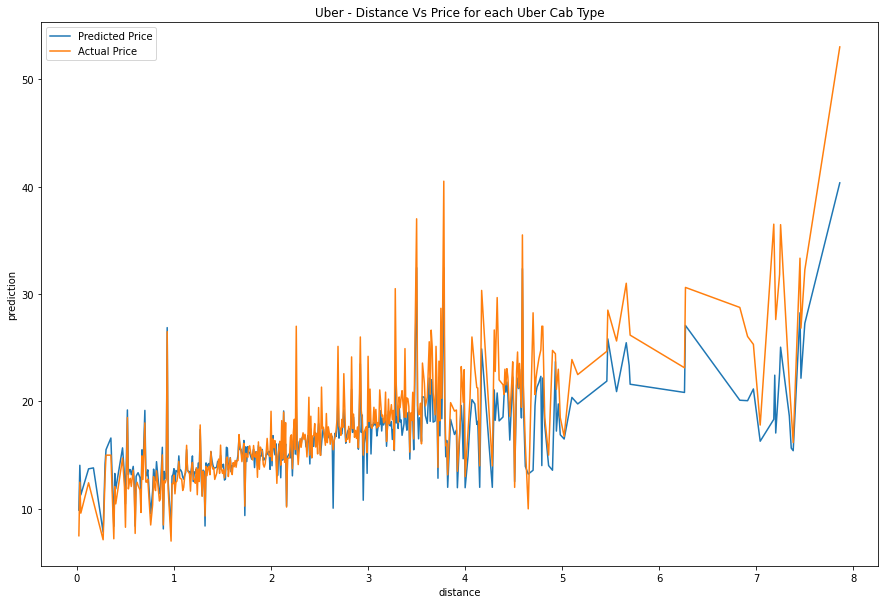

In [ ]:
#2.
plt.figure(figsize=(15, 10))
sns.lineplot(data=pred_pd, x="distance", y="prediction",ci=None).set_title("Uber - Distance Vs Price for each Uber Cab Type");
sns.lineplot(data=pred_pd, x="distance", y="label",ci=None).set_title("Uber - Distance Vs Price for each Uber Cab Type");
plt.legend(labels=["Predicted Price","Actual Price"])

In [ ]:
enable_grid = False
if enable_grid == False:
    all_models = []
    grid = ParamGridBuilder().\
    addGrid(rf.maxDepth, [5,7,13,15]).\
    addGrid(rf.numTrees,[10,20,30,40,50]).\
    build()
    grid
    rf_pipe_1 = Pipeline(stages=[va,rf])
    for j in range(len(grid)):
        model = rf_pipe_1.fit(train_df,grid[j])
        all_models.append(model)
    pass

In [ ]:
accuracies = [m.\
transform(validate_df).\
select(fn.avg(fn.expr('float(prediction)')).alias('accuracy')).\
first().\
accuracy for m in all_models]
accuracies
best_model_idx = np.argmax(accuracies)
print(grid[best_model_idx])

{Param(parent='RandomForestRegressor_f52fad739e62', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 13, Param(parent='RandomForestRegressor_f52fad739e62', name='numTrees', doc='Number of trees to train (>= 1).'): 10}


In [ ]:
rf_new = regression.RandomForestRegressor(labelCol="label",featuresCol="features",maxDepth = 5, numTrees = 40)

In [ ]:
rf_pipe_new = Pipeline(stages = [va,rf_new]).fit(train_df)

In [ ]:
pred_df_rf = rf_pipe_new.transform(test_df)

In [ ]:
evaluator =   RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
accuracy = evaluator.evaluate(pred_df_rf)

In [ ]:
accuracy

0.9261527016938208

#CORRELATION FOR LYFT

In [ ]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/Lyft-3.csv")
df.show(5)

+---+----+---+----------------+-------------+--------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+
|_c0|hour|day|          source|  destination|cab_type|        name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureLowTime|dewPoint|pressure|windBearing|cloudCover|uvIndex|ozon

In [ ]:
clean_df = df.drop('_c0')

In [ ]:
hour_list = clean_df.select('hour').rdd.flatMap(lambda x: x).collect()
time_of_day = []
for i in hour_list:
  if hour_list[i] >= 4 and hour_list[i] <=8:
    time_of_day.append("Early Morning")
  elif hour_list[i] > 8 and hour_list[i] <=12:
    time_of_day.append("Morning")
  elif hour_list[i] > 12 and hour_list[i] <=16:
    time_of_day.append("Afternoon")
  elif hour_list[i] > 16 and hour_list[i] <=20:
    time_of_day.append("Evening")
  elif hour_list[i] > 20 and hour_list[i] <= 24:
    time_of_day.append("Night")
  else:
     time_of_day.append("Late Night")

from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

b = spark.createDataFrame([(l,) for l in time_of_day], ['Time_of_day'])

#adding 'sequential' index and join both dataframe to get the final result
clean_df = clean_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = b.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

clean_df = clean_df.join(b, clean_df.row_idx == b.row_idx).\
             drop("row_idx")



In [ ]:
Cab_indexer = feature.StringIndexerModel.from_labels(['Shared','Lyft','Lyft XL','Lux','Lux Black','Lux Black XL'], inputCol ="name", outputCol='Cab_category_num')


weather_indexer = feature.StringIndexerModel.from_labels([' Clear ',' Partly Cloudy ',' Mostly Cloudy ',' Overcast ', ' Foggy ',' Possible Drizzle ',' Drizzle ',' Light Rain ',' Rain '], inputCol ="short_summary", outputCol='Weather_num')


time_indexer = feature.StringIndexerModel.from_labels(['Early Morning','Morning','Afternoon','Evening','Night','Late Night'], inputCol ="Time_of_day", outputCol='time_of_day_num')


source_indexer = feature.StringIndexerModel.from_labels(['Haymarket Square', 'Back Bay', 'North End', 'North Station',
       'Beacon Hill', 'Boston University', 'Fenway', 'South Station',
       'Theatre District', 'West End', 'Financial District',
       'Northeastern University'], inputCol ="source", outputCol='source_num')


destination_indexer = feature.StringIndexerModel.from_labels(['Haymarket Square', 'Back Bay', 'North End', 'North Station',
       'Beacon Hill', 'Boston University', 'Fenway', 'South Station',
       'Theatre District', 'West End', 'Financial District',
       'Northeastern University'], inputCol ="destination", outputCol='destination_num')

surge_Indexer = feature.StringIndexerModel.from_labels(['1.0','1.25','1.5','1.75','2.0','2.5','3.0'], inputCol="surge_multiplier", outputCol = "surge_num")



In [ ]:
from pyspark.ml import Pipeline
indexer_pipeline = Pipeline(stages = [source_indexer,destination_indexer,Cab_indexer,time_indexer,surge_Indexer,weather_indexer])

clean_df = indexer_pipeline.fit(clean_df).transform(clean_df)

In [ ]:
from pyspark.sql.functions import concat, lit, col
from pyspark.ml.feature import StringIndexer

clean_df=clean_df.select("*", concat(col("source_num"),lit("-"),col("destination_num")).alias("Route"))

indexer = StringIndexer(inputCol="Route", outputCol="Route_num").fit(clean_df)
clean_df = indexer.transform(clean_df)
clean_df.show()


+----+---+----------------+--------------------+--------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+-------------+----------+---------------+----------------+---------------+---------+-----------+--------+---------+
|hour|day|          source|         destination|cab_type|        name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTe

In [ ]:
clean_df.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- surge_multiplier: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- apparentTemperature: double (nullable = true)
 |-- short_summary: string (nullable = true)
 |-- long_summary: string (nullable = true)
 |-- precipIntensity: double (nullable = true)
 |-- precipProbability: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- windSpeed: double (nullable = true)
 |-- windGust: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- temperatureHigh: double (nullable = true)
 |-- temperatureLow: double (nullable = true)
 |-- apparentTemperature

In [ ]:
get_df = clean_df.select('source','destination','Route_num','name','Time_of_day','time_of_day_num')
clean_df = clean_df.drop('source','destination','Cab_category','short_summary','Time_of_day','Route','surge_multiplier','cab_type','name','long_summary')

In [ ]:
get_df.show()

+----------------+--------------------+---------+------------+-------------+---------------+
|          source|         destination|Route_num|        name|  Time_of_day|time_of_day_num|
+----------------+--------------------+---------+------------+-------------+---------------+
|Haymarket Square|       North Station|     18.0|      Shared|      Morning|            1.0|
|Haymarket Square|       North Station|     18.0|         Lux|   Late Night|            5.0|
|Haymarket Square|       North Station|     18.0|        Lyft|   Late Night|            5.0|
|Haymarket Square|       North Station|     18.0|Lux Black XL|   Late Night|            5.0|
|Haymarket Square|       North Station|     18.0|     Lyft XL|Early Morning|            0.0|
|Haymarket Square|       North Station|     18.0|   Lux Black|   Late Night|            5.0|
|        Back Bay|Northeastern Univ...|     30.0|     Lyft XL|      Evening|            3.0|
|        Back Bay|Northeastern Univ...|     30.0|   Lux Black|      Ev

In [ ]:
clean_df = clean_df.drop('apparentTemperatureHighTime','apparentTemperatureLowTime')

In [ ]:
import seaborn as sns

In [ ]:
route_10= get_df.select('source','destination','Route_num','name')
route_freq = route_10.groupBy(['source','destination','Route_num']).count()
plot_df = route_freq.sort('count',ascending=False)
plot_df.show()

+------------------+--------------------+---------+-----+
|            source|         destination|Route_num|count|
+------------------+--------------------+---------+-----+
|     South Station|  Financial District|      1.0| 4626|
|Financial District|       South Station|      0.0| 4626|
|         North End|            Back Bay|      3.0| 4548|
|          Back Bay|           North End|      2.0| 4548|
|            Fenway|            West End|      4.0| 4530|
|          West End|              Fenway|      5.0| 4530|
|  Haymarket Square|  Financial District|      6.0| 4506|
|Financial District|    Haymarket Square|      7.0| 4505|
|       Beacon Hill|           North End|      9.0| 4446|
|         North End|         Beacon Hill|      8.0| 4446|
| Boston University|    Theatre District|     10.0| 4416|
|  Theatre District|   Boston University|     11.0| 4416|
| Boston University|            West End|     12.0| 4398|
|          West End|   Boston University|     13.0| 4392|
|Financial Dis

In [ ]:
plot_pd_df = plot_df.toPandas()
plot_pd_df = plot_pd_df[:5]

Text(0.5, 1.0, 'Top 5 Source for booking a Lyft Cab')

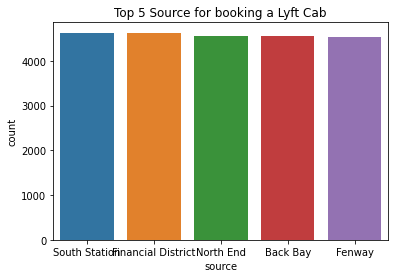

In [ ]:
ax = sns.barplot(x="source", y= "count",data=plot_pd_df)
plt.title("Top 5 Source for booking a Lyft Cab")

In [ ]:
get_df.show()

+----------------+--------------------+---------+------------+-------------+---------------+
|          source|         destination|Route_num|        name|  Time_of_day|time_of_day_num|
+----------------+--------------------+---------+------------+-------------+---------------+
|Haymarket Square|       North Station|     18.0|      Shared|      Morning|            1.0|
|Haymarket Square|       North Station|     18.0|         Lux|   Late Night|            5.0|
|Haymarket Square|       North Station|     18.0|        Lyft|   Late Night|            5.0|
|Haymarket Square|       North Station|     18.0|Lux Black XL|   Late Night|            5.0|
|Haymarket Square|       North Station|     18.0|     Lyft XL|Early Morning|            0.0|
|Haymarket Square|       North Station|     18.0|   Lux Black|   Late Night|            5.0|
|        Back Bay|Northeastern Univ...|     30.0|     Lyft XL|      Evening|            3.0|
|        Back Bay|Northeastern Univ...|     30.0|   Lux Black|      Ev

In [ ]:
time_freq = get_df.groupBy(['Time_of_day','source']).count()
plot_df2 = time_freq.sort('count',ascending=False)
plot_df2.show()

+-----------+--------------------+-----+
|Time_of_day|              source|count|
+-----------+--------------------+-----+
| Late Night|    Theatre District| 6658|
| Late Night|              Fenway| 6623|
| Late Night|    Haymarket Square| 6536|
| Late Night|Northeastern Univ...| 6524|
| Late Night|            Back Bay| 6523|
| Late Night|           North End| 6511|
| Late Night|  Financial District| 6471|
| Late Night|   Boston University| 6425|
| Late Night|       South Station| 6410|
| Late Night|         Beacon Hill| 6395|
| Late Night|            West End| 6371|
| Late Night|       North Station| 6317|
|    Evening|    Haymarket Square| 6301|
|    Evening|           North End| 6272|
|    Evening|  Financial District| 6209|
|    Evening|            Back Bay| 6190|
|    Evening|Northeastern Univ...| 6176|
|    Evening|            West End| 6088|
|    Evening|       North Station| 6072|
|    Evening|              Fenway| 6065|
+-----------+--------------------+-----+
only showing top

In [ ]:
#top routes during morning
plot_pd_df2 = plot_df2.toPandas()
plot_pd_df2= plot_pd_df2.loc[plot_pd_df2['Time_of_day'] == 'Morning']
plot_pd_df2= plot_pd_df2.sort_values('count',ascending=False)
plot_pd_df2 = plot_pd_df2[:10]

Text(0.5, 1.0, 'top routes during morning')

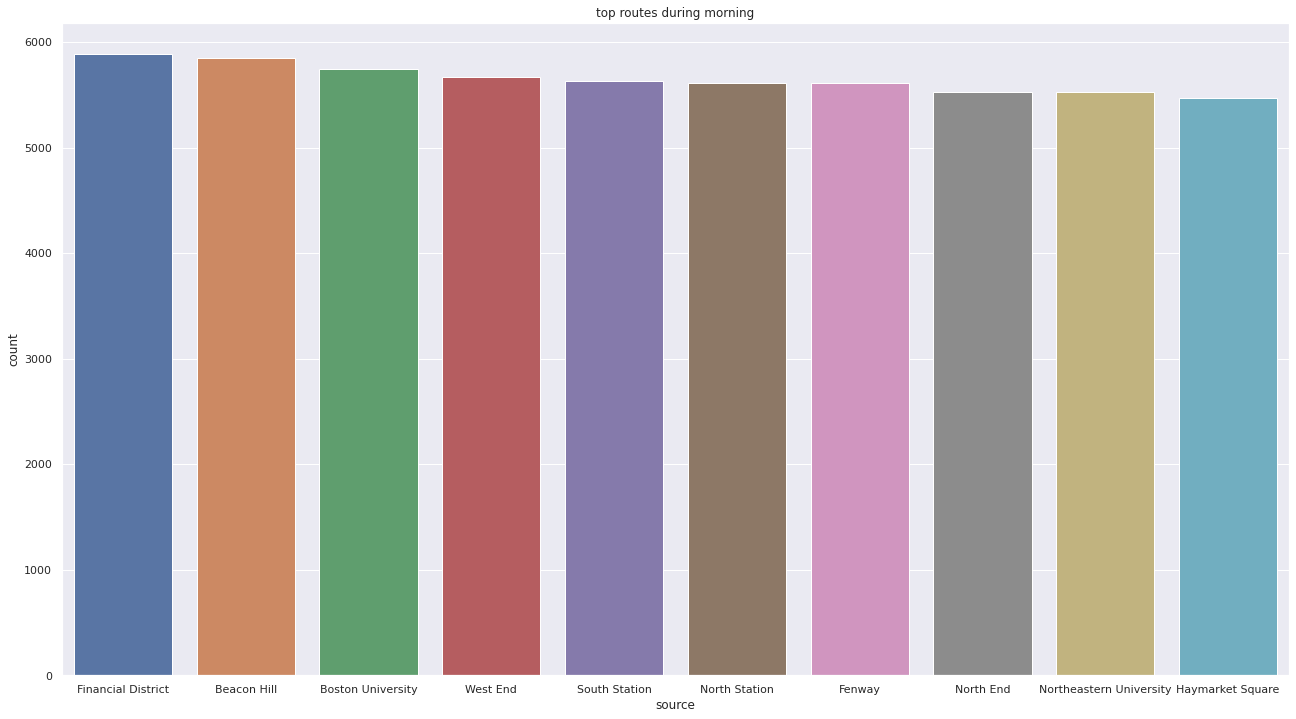

In [ ]:
plot = sns.set(rc = {'figure.figsize':(22,12)})
ax = sns.barplot(x= "source",y="count",data=plot_pd_df2)
plt.title("top routes during morning")

In [ ]:
Lyft_pandas = clean_df.toPandas()

In [ ]:
temp_time = df.select('temperature','apparentTemperature',\
                         'temperatureHigh', \
                         'temperatureLow',\
                         'apparentTemperatureHigh',\
                         'apparentTemperatureLow',\
                         'temperatureMin',\
                         'temperatureMax',\
                         'apparentTemperatureMin',\
                         'apparentTemperatureMax','price')

In [ ]:
temp_cols = temp_time.columns

+-----------+-------------------+---------------+--------------+-----------------------+----------------------+--------------+--------------+----------------------+----------------------+-----+--------------------+
|temperature|apparentTemperature|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureLow|temperatureMin|temperatureMax|apparentTemperatureMin|apparentTemperatureMax|price|            features|
+-----------+-------------------+---------------+--------------+-----------------------+----------------------+--------------+--------------+----------------------+----------------------+-----+--------------------+
|      42.34|              37.12|          43.68|         34.19|                  37.95|                 27.39|         39.89|         43.68|                 33.73|                 38.07|  5.0|[42.34,37.12,43.6...|
|      43.58|              37.35|           47.3|          42.1|                  43.92|                  36.2|         40.49|          47.3

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


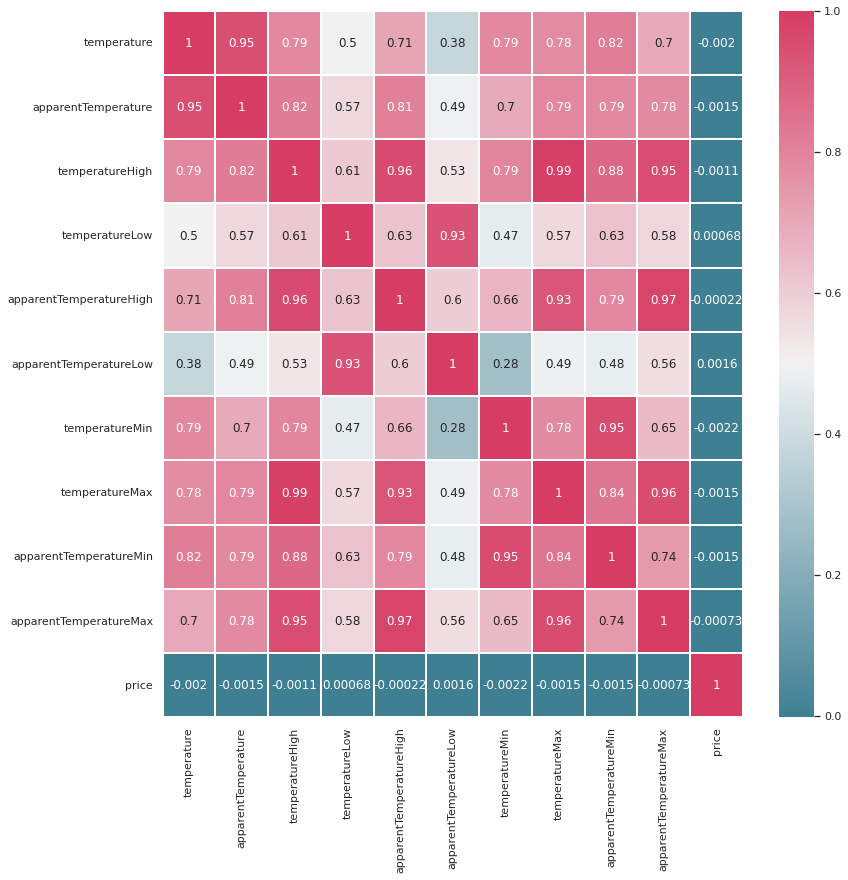

In [ ]:
from pyspark.ml import feature
from pyspark.ml.stat import Correlation

corr_assembler_climate = feature.VectorAssembler(inputCols = temp_cols,outputCol = "features").transform(temp_time)
corr_assembler_climate.show()

corr_climate = Correlation.corr(corr_assembler_climate,"features").collect()[0][0]
climateCorr_array = corr_climate.toArray().tolist()

#plots a heatmap which shows the correlation of each column with respect to others
cmap = sns.diverging_palette(220,2,as_cmap = True)
plt.figure(figsize=(13,13))
sns.heatmap(climateCorr_array,linewidth=1.0,cmap=cmap,annot=True,yticklabels=temp_cols,xticklabels=temp_cols)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


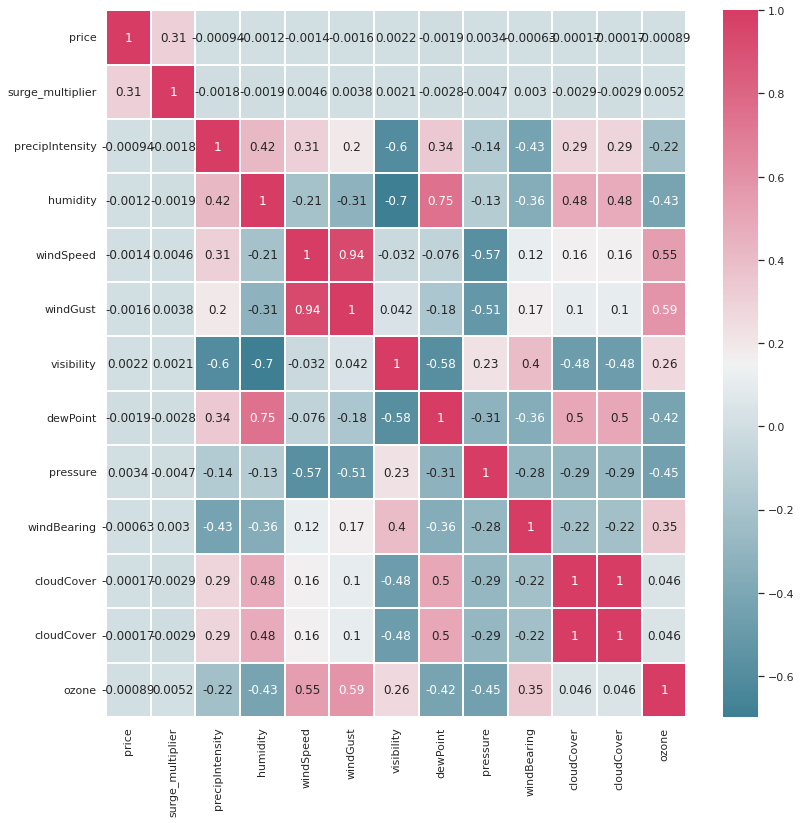

In [ ]:
climate = df.select('price','surge_multiplier','precipIntensity','humidity','windSpeed','windGust','visibility','dewPoint','pressure','windBearing','cloudCover','cloudCover','ozone')
climate_cols = climate.columns

corr_assembler_climate2 = feature.VectorAssembler(inputCols = climate_cols,outputCol = "features").transform(climate)

corr_climate2 = Correlation.corr(corr_assembler_climate2,"features").collect()[0][0]
climateCorr_array2 = corr_climate2.toArray().tolist()

#plots a heatmap which shows the correlation of each column with respect to others
cmap = sns.diverging_palette(220,2,as_cmap = True)
plt.figure(figsize=(13,13))
sns.heatmap(climateCorr_array2,linewidth=1.0,cmap=cmap,annot=True,yticklabels=climate_cols,xticklabels=climate_cols)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


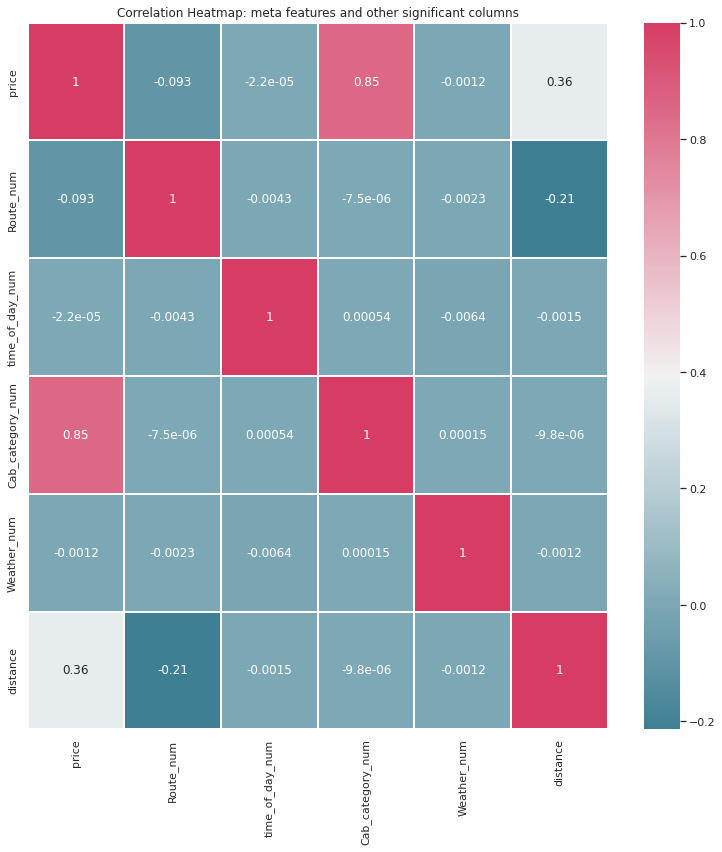

In [ ]:
clean_cols = ['price','Route_num','time_of_day_num','Cab_category_num','Weather_num','distance']
corr_assembler_clean = feature.VectorAssembler(inputCols = clean_cols,outputCol = "features").transform(clean_df)

corr_clean = Correlation.corr(corr_assembler_clean,"features").collect()[0][0]
cleanCorr_array = corr_clean.toArray().tolist()

#plots a heatmap which shows the correlation of each column with respect to others
cmap = sns.diverging_palette(220,2,as_cmap = True)
plt.figure(figsize=(13,13))
plt.title("Correlation Heatmap: meta features and other significant columns")
sns.heatmap(cleanCorr_array,linewidth=1.0,cmap=cmap,annot=True,yticklabels=clean_cols,xticklabels=clean_cols)

In [ ]:
training_df,testing_df,validation_df = clean_df.randomSplit([0.6,0.2,0.2])
def col_sel(cols):
  best_cols = ["price"]
  models_consider = []
  r2_vals = []
  r2_final = 0
  for i in cols:
    if i not in best_cols:
      best_cols.append(i)
      print(i)
      va_cols = best_cols[1:]
      va = feature.VectorAssembler(inputCols=va_cols,outputCol="features")
      lr = regression.LinearRegression(featuresCol = "features",labelCol = "price")
      forward_pipe = Pipeline(stages = [va,lr])
      print("Executing ", best_cols)
      model_df = training_df.select(best_cols)
      pipe_fit = forward_pipe.fit(model_df)
      transformed_df = pipe_fit.transform(model_df)
      lr_model = pipe_fit.stages[-1]
      r2_score = lr_model.summary.r2
      print(r2_score)
      #r2_vals.append(r2_score)
      if r2_score != 1:
        r2_vals.append(r2_score)
        if r2_score > r2_final:
          r2_final = r2_final+r2_score
          models_consider.append(i)
          print(r2_vals)
          print("Model Consider: ",models_consider)
          print("################################")

  return models_consider

In [ ]:
col_sel(clean_df.columns)

hour
Executing  ['price', 'hour']
6.600524191657797e-07
[6.600524191657797e-07]
Model Consider:  ['hour']
################################
day
Executing  ['price', 'hour', 'day']
7.180720801303053e-07
[6.600524191657797e-07, 7.180720801303053e-07]
Model Consider:  ['hour', 'day']
################################
distance
Executing  ['price', 'hour', 'day', 'distance']
0.13073964818130968
[6.600524191657797e-07, 7.180720801303053e-07, 0.13073964818130968]
Model Consider:  ['hour', 'day', 'distance']
################################
latitude
Executing  ['price', 'hour', 'day', 'distance', 'latitude']
0.1307493618481742
[6.600524191657797e-07, 7.180720801303053e-07, 0.13073964818130968, 0.1307493618481742]
Model Consider:  ['hour', 'day', 'distance', 'latitude']
################################
longitude
Executing  ['price', 'hour', 'day', 'distance', 'latitude', 'longitude']
0.13074959314342283
temperature
Executing  ['price', 'hour', 'day', 'distance', 'latitude', 'longitude', 'temperat

['hour', 'day', 'distance', 'latitude', 'Cab_category_num']

In [ ]:
get_df.show(5)

+----------------+-------------+---------+------------+-------------+---------------+
|          source|  destination|Route_num|        name|  Time_of_day|time_of_day_num|
+----------------+-------------+---------+------------+-------------+---------------+
|Haymarket Square|North Station|     18.0|      Shared|      Morning|            1.0|
|Haymarket Square|North Station|     18.0|         Lux|   Late Night|            5.0|
|Haymarket Square|North Station|     18.0|        Lyft|   Late Night|            5.0|
|Haymarket Square|North Station|     18.0|Lux Black XL|   Late Night|            5.0|
|Haymarket Square|North Station|     18.0|     Lyft XL|Early Morning|            0.0|
+----------------+-------------+---------+------------+-------------+---------------+
only showing top 5 rows



#LINEAR REGRESSION FOR LYFT - PRICE PREDICTION

In [ ]:
va = feature.VectorAssembler(inputCols = ['hour', 'day', 'distance', 'precipIntensity', 'Cab_category_num'],outputCol = "features")

lr = regression.LinearRegression(featuresCol = "features",labelCol = "price",predictionCol='prediction')
lr_pipe = Pipeline(stages=[va,lr]).fit(training_df)
lr_pipe.transform(testing_df)
mse = fn.mean((fn.col('price') - fn.col('prediction'))**2).alias('mse') # Calculating the mean squared error
lr_pipe.transform(testing_df).select(mse).show() # Displaying the mse
lr_pipe.transform(validation_df).select(mse).show() # Displaying the mse

lr_model = lr_pipe.stages[-1]
print(lr_model.coefficients)

print("Intercept: ",lr_model.intercept)

lr_model.summary.rootMeanSquaredError
print("R2: ",lr_model.summary.r2)

+------------------+
|               mse|
+------------------+
|14.611850345450655|
+------------------+

+------------------+
|               mse|
+------------------+
|15.559524997578796|
+------------------+

[8.796055110665985e-05,0.001204625218095101,3.3295209865043573,-0.17845494972079107,4.977624818331846]
Intercept:  -2.3970872417013243
R2:  0.8522271726132558


In [ ]:
coeff_tuple = list(zip(input_cols,list(lr_model.coefficients)))
coeff_df = pd.DataFrame(coeff_tuple).rename(columns = {0:"Features",1:"Coefficients"})
coeff_df

,Features,Coefficients
0,name_categorical,0.000088
1,distance,0.001205


In [ ]:
enable_grid = False
if enable_grid == False:
    all_models = []
    grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0., 0.05, 0.10,0.20]).\
    addGrid(lr.elasticNetParam,[0.0,0.2,0.4,0.6,0.8]).\
    build()
    grid
    lr_pipe_1 = Pipeline(stages=[va,lr])
    for j in range(len(grid)):
        model = lr_pipe_1.fit(training_df,grid[j])
        all_models.append(model)
    pass

In [ ]:
accuracies = [m.\
transform(validation_df).\
select(fn.avg(fn.expr('float(prediction)')).alias('accuracy')).\
first().\
accuracy for m in all_models]
accuracies
best_model_idx = np.argmax(accuracies)
print(grid[best_model_idx])

{Param(parent='LinearRegression_bd79a29b2068', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LinearRegression_bd79a29b2068', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}


In [ ]:
from pandas._libs.tslibs.timedeltas import parse_timedelta_unit
lr_new = regression.LinearRegression(featuresCol = "features",labelCol = "price",regParam=0.0,elasticNetParam=0.0)

In [ ]:
lr_pipe_new = Pipeline(stages = [va,lr_new]).fit(training_df)

In [ ]:
lr_pipe_new.transform(testing_df).select(mse).show()

+------------------+
|               mse|
+------------------+
|14.611850345450655|
+------------------+



In [ ]:
lr_model_new = lr_pipe_new.stages[-1]
lr_model_new.summary.r2

0.8522271726132558

In [ ]:
lr_pipe_new.transform(validation_df).select(mse).show()

lr_model_new = lr_pipe_new.stages[-1]
lr_model_new.summary.r2

+------------------+
|               mse|
+------------------+
|15.559524997578796|
+------------------+



0.8522271726132558